# Sensitivity analysis <br>
**This notebook demonstrates how our parameters affect the classifications of roads** <br>

More parameters can be added and analyzed

In [225]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import warnings
os.environ['USE_PYGEOS']='0'

# Display all columns in the df
pd.set_option('display.max_columns', None)
# Set the float format to display numbers in standard decimal notation
pd.options.display.float_format = '{:.5f}'.format
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 



#Read csv
df=pd.read_excel(r"/Users/antonglad/Desktop/Python_Recreation/sensitivity/CS_Volume_Roads.xlsx")

## Creation of main processing function

In [226]:
#Wrapping the code that calculates the probabilities and predicts demand is a necessary procedure for later running sensititives
#Define function which calculates main dataframe values
def process_df(ev_ratio, df): 
    df=df.copy()
    #Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
    df["range"]=300

    #Creating dictionairy showcasing the loss of range per season 
    temp_cost={'january':0.8, 
            'february':0.8, 
            'march':0.8, 
            'april':0.9, 
            'may':1, 
            'june':1.05, 
            'july':1.1, 
            'august':1.1, 
            'september':1.02, 
            'october':0.92, 
            'november':0.82, 
            'december':0.8} 

    #Part of Method 1
    for key in temp_cost.keys():
        df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]



    # Define a dictionary to map the old column names to the new column names
    col_map = {i: f"vol_{month[:3].lower().strip()}" for i, month in zip(range(1, 13), temp_cost.keys())}

    # Manually change the column names
    new_names = {1: 'vol_jan', 2: 'vol_feb', 3: 'vol_mar', 4: 'vol_apr', 5: 'vol_may', 6: 'vol_jun', 7: 'vol_jul', 8: 'vol_aug', 9: 'vol_sep', 10: 'vol_oct', 11: 'vol_nov', 12: 'vol_dec'}

    # Rename the columns using the dictionary
    df = df.rename(columns=new_names)

    # Loop through each row of the dataframe
    for index, row in df.iterrows():
        # Calculate the mean of the non-missing values in the row
        row_mean = int(row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True))

        # Fill the missing values in the row with the row mean
        df.loc[index] = row.fillna(row_mean)


    # Find charging probability distribution
    #Formula: p = edge_length / battery_range (actual)

    #Method 1: Decreases the range by a factor of temperature
    # # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_prob_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)
        df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)


    ################################################################
    
    #public_charging=X

    # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_cars_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
        df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio) #*public_charging
        df[col_name] = df[col_name].astype(int)



    # Define a list of the column names to convert to integer type
    cols_to_convert = ['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 
                    'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec', 
                    'range', 'actual_range_jan', 'actual_range_feb', 'actual_range_mar', 
                    'actual_range_apr', 'actual_range_may', 'actual_range_jun', 
                    'actual_range_jul', 'actual_range_aug', 'actual_range_sep', 
                    'actual_range_oct', 'actual_range_nov', 'actual_range_dec']

    # Convert the columns to integer type
    df[cols_to_convert] = df[cols_to_convert].astype(int)


    return df


## Finding hourly traffic patterns

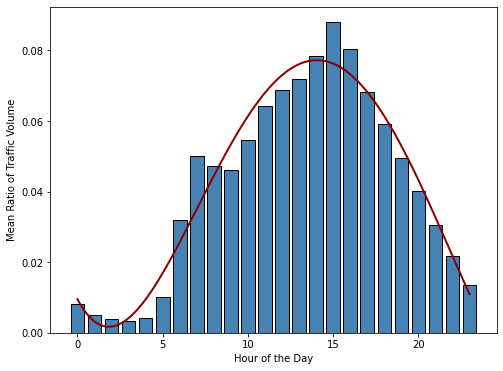

In [227]:
import pandas as pd
from scipy.interpolate import make_interp_spline, UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt

#Investigating real traffic hourly patterns of the day based on real data (not pivoted spreadsheet)
hourly=pd.read_csv(r"/Users/antonglad/Desktop/Python_Recreation/completeAllHourlyVolume_EasterAprJulSep.csv")

# Group the DataFrame by hour and sum the traffic volume
total_traffic_by_hour = hourly.groupby(['from_hour'])['volume'].sum()

# Calculate the total traffic volume for the entire day
total_traffic = hourly['volume'].sum()

# Calculate the mean ratio for each hour of the day
mean_ratios = total_traffic_by_hour / total_traffic


# Convert the mean ratios to a list
mean_ratios_list = mean_ratios.tolist()

# Create a list of the hour values
hours = mean_ratios.index.tolist()

# # Extract just the hour from the from_hour column
# hours = [x.split(':')[0] for x in hours]

# Extract just the hour from the from_hour column
hours = [int(x.split(':')[0]) for x in hours]  # Convert to integers

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create the histogram
ax.bar(hours, mean_ratios_list, edgecolor='black', color="steelblue")

# Set the x-axis label
ax.set_xlabel('Hour of the Day')

# Set the y-axis label
ax.set_ylabel('Mean Ratio of Traffic Volume')

# Generate the spline
x_smooth = np.linspace(min(hours), max(hours), 200)
#spl = make_interp_spline(hours, mean_ratios_list, k=3)  #Smoothing method 1 : more precise (less nice)
spl = UnivariateSpline(hours, mean_ratios_list, k=4, s=1)  # Smoothing method 2 : less precise, more smooth (more nice)
y_smooth = spl(x_smooth)
# Add the spline to the plot
ax.plot(x_smooth, y_smooth, 'r-', color="darkred", lw=2)

# Show the plot
plt.show()

In [146]:
df.head()

,Unnamed: 0,source,target,length,CS_id,geometry,Level,PowerKW_list,Number_Of_Chargers,Name,traffic_id,1,2,3,4,5,6,7,8,9,10,11,12
0,0,794436,735703,11865.76308,243288,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0]",6,Alna senter,59192V1878201,34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000
1,1,794436,735703,11865.76308,46650,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0]",2,"Circle K Økern Hurtigladestasjon, Oslo",59192V1878201,34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000
2,2,794436,735703,11865.76308,46721,LINESTRING (10.733792828475945 59.909993840978...,3,"[44.0, 44.0]",2,"Fortum hurtigladestasjon Kiwi Bjerke, Oslo",59192V1878201,34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000
3,3,794436,735703,11865.76308,243279,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 150.0, 150.0]",6,Recharge McDonald´s Alnabru,59192V1878201,34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000
4,4,794436,735703,11865.76308,157384,LINESTRING (10.733792828475945 59.909993840978...,3,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....",10,Obs Haugenstua,59192V1878201,34276.00000,35539.00000,35016.00000,38122.00000,37843.00000,41610.00000,30198.00000,38625.00000,38102.00000,39098.00000,38699.00000,33801.00000


## Creation of Charging JSON - used to calculate supply

In [228]:
import pandas as pd
import json
from json import JSONEncoder
import ast


class CustomJSONEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.core.series.Series):
            return obj.tolist()
        return super(CustomJSONEncoder, self).default(obj)

# Assuming your dataframe is called 'df'
charging_cols = ['source', 'target', 'CS_id', 'PowerKW_list', 'Number_Of_Chargers', 'Name']

# Create a new DataFrame with the selected columns
cs_data = df[charging_cols].copy()

#Changing names of source and target
new_names_2 = {'source': 'u', 'target': 'v'}
cs_data = cs_data.rename(columns=new_names_2) 


# Create a new DataFrame with rows where 'PowerKW_list' is 'No CS' (This will be used for experiments)
no_cs_df = cs_data.loc[cs_data['PowerKW_list'] == 'No CS'].copy()
#Export the roads with no charging stations to CSV
#no_cs_df.to_csv("roads_without_CS.csv")

# Initialize an empty dictionary to store the data
data_dict = {}

# Iterate through the dataframe rows
for index, row in cs_data.iterrows():
    # Create a key for the unique combination of 'u' and 'v'
    key = f"{row['u']}_{row['v']}"

    # If the key is not in the dictionary, create a new entry
    if key not in data_dict:
        data_dict[key] = {'CS_ids': [], 'PowerKW_lists': []}

    # Append the CS_id and PowerKW_list for the current row to the corresponding lists
    data_dict[key]['CS_ids'].append(row['CS_id'])
    if row['PowerKW_list'] == "No CS":
        data_dict[key]['PowerKW_lists'].append("No CS")
    else:
        data_dict[key]['PowerKW_lists'].append([float(x) for x in ast.literal_eval(row['PowerKW_list'])])
# Convert the dictionary to a JSON object
json_data = json.dumps(data_dict, indent=2, cls=CustomJSONEncoder)


# assume `json_str` contains your JSON formatted string
with open('edge_cs_data.json', 'w') as f:
    f.write(json_data)


# Load the JSON data
with open('edge_cs_data.json') as f:
    data = json.load(f)

# Iterate through each element of the PowerKW_lists arrays
for key, value in data.items():
    for i, lst in enumerate(value['PowerKW_lists']):
        # Use a list comprehension to filter out the values that are equal to 22
        filtered_lst = [x for x in lst if x not in [22.0, 25.0]]
        # Replace the original list with the filtered list
        value['PowerKW_lists'][i] = filtered_lst

# Save the updated JSON data
with open('updated_json_file.json', 'w') as f:
    json.dump(data, f, indent=2)


## Creation of supply and demand variables function

In [229]:
#More parameters can be added in the function

def process_json(df, mean_ratios, avg_bat):

    #Dictionary containing the amount of cars that can charge per hour at chargers with different capacities (data from Excel spreadsheet)
    # Define the kW types of chargers
    kW_list = [350, 300, 250, 200, 180, 175, 150, 135, 129, 125, 120, 100, 75, 62.5, 62, 60, 55, 50, 48, 44, 43]

    # Define the average battery capacity
    #avg_bat = 68
    battery_aging_ratio=0.9

    avg_bat*=battery_aging_ratio

    # Define the setup and takedown time (in minutes)
    setup_takedown_time = 5

    # Convert setup and takedown time to hours
    setup_takedown_time_hours = setup_takedown_time / 60

    # Initialize an empty dictionary
    cars_per_hour_dict = {}

    # Loop through the kW list
    for kW in kW_list:
        # Calculate charging time
        charging_time = avg_bat / kW

        # Add the setup and takedown time to the charging time
        total_time = charging_time + setup_takedown_time_hours

        # Calculate cars per hour and round it to 1 decimal place
        cars_per_hour = round(1 / total_time, 1)

        # Add this to the dictionary
        cars_per_hour_dict[kW] = cars_per_hour

    # # Print out the resulting dictionary
    # for kW, cars_per_hour in cars_per_hour_dict.items():
    #     print(f"{kW}: {cars_per_hour}")

    # Load the updated JSON data
    with open('updated_json_file.json') as f:
        python_data = json.load(f)

    # Create an empty list to hold the calculated values
    calc_values = []

    # Loop over each ID in the Python object
    for id_, values in python_data.items():
        # Skip the iteration if either "CS_ids" or "PowerKW_lists" keys have invalid values
        if not values['CS_ids'] or not all(isinstance(power, (float, int)) for power_list in values['PowerKW_lists'] for power in power_list):
            continue
        # Calculate the total capacity for the ID by summing the capacities in the "PowerKW_lists" key
        total_capacity = sum([sum([cars_per_hour_dict[power] for power in power_list]) for power_list in values['PowerKW_lists']])
        
        # Append the ID and calculated value to the list
        calc_values.append((id_, total_capacity))

    # Create a DataFrame from the list of calculated values
    edge_supply = pd.DataFrame(calc_values, columns=['ID', 'CalcValue'])
    edge_supply = edge_supply.rename(columns={'ID': 'new_id'})

    #Changing names of source and target
    new_names_3 = {'source': 'u', 'target': 'v'}
    df = df.rename(columns=new_names_3) 

    df["new_id"] = df["u"].astype(str) + "_" + df["v"].astype(str)

    # Assuming the other dataframe is called "other_df"
    merged_df = df.merge(edge_supply, on='new_id')

    merged_df = merged_df.rename(columns={'CalcValue': 'Charge_Supply'})

    unique_counts = merged_df['Charge_Supply'].value_counts()
    unique_values = unique_counts.index.tolist()
    occurrences = unique_counts.tolist()

    #for i in range(len(unique_values)):
        #print("Value: {}, Occurrences: {}".format(unique_values[i], occurrences[i]))


    #New dataframe creation which excludes duplicates rows (results in as many rows as edges)
    every_edge= merged_df.drop_duplicates(subset='new_id', keep='first')


    # Helper function to distribute the cars per edge using the mean_ratios: Not needed
    def distribute_cars(cars, mean_ratios):
        return [cars * ratio for ratio in mean_ratios]

    # Extract hour ratios from mean_ratios
    hour_ratios = mean_ratios.values.tolist()


    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize an empty dictionary to store the DataFrames for each month
    monthly_dfs = {}

    # Iterate over each month
    for month in months:
        # Create a new DataFrame with the same index as new_df
        monthly_df = every_edge[['u', 'v']].copy()
        
        # Distribute cars for each edge and each hour of the day
        for hour, ratio in enumerate(hour_ratios):
            hourly_column_name = f'hour_{hour:02d}_{month}'
            monthly_df[hourly_column_name] = every_edge[f'charge_cars_{month}'].mul(ratio)


        
        # Store the resulting DataFrame in the dictionary
        monthly_dfs[month] = monthly_df


    # Initialize an empty dictionary to store the DataFrames for each month
    supply_demand_difference = {}

    # Iterate over each month
    for month in months:
        # Get the corresponding DataFrame for the month
        monthly_df = monthly_dfs[month].copy()
        
        # Iterate over each hour of the day
        for hour in range(24):
            hourly_column_name = f'hour_{hour:02d}_{month}'
            
            # Calculate the supply-demand difference for each hour
            supply_demand_difference_hour = every_edge['Charge_Supply'] - monthly_df[hourly_column_name]
            
            # Replace the hourly column with the supply-demand difference
            diff_hourly_column_name = f'diff_hour_{hour:02d}_{month}'
            monthly_df[diff_hourly_column_name] = supply_demand_difference_hour

            # Drop the original hourly column
            monthly_df = monthly_df.drop(hourly_column_name, axis=1)
        
        # Add edge classification to the monthly DataFrame
        # Create a DataFrame to store the classification
        classification_df = pd.DataFrame(index=monthly_df.index, columns=["edge_classification"])


        # Iterate over the edges
        for edge in monthly_df.index:
            # Get the supply-demand difference values for the edge
            diff_values = monthly_df.loc[edge][2:]
            
            # Check if all values are positive
            if (diff_values > 0).all():
                classification = 1
            # Check if all values are negative
            elif (diff_values < 0).all():
                classification = -1
            # Otherwise, the values are mixed
            else:
                classification = 0
            
            # Store the classification for the edge
            classification_df.loc[edge, "edge_classification"] = classification

        # Merge the classification DataFrame with the monthly DataFrame
        monthly_df = pd.concat([monthly_df, classification_df], axis=1)

        # Store the resulting DataFrame in the dictionary
        supply_demand_difference[month] = monthly_df

    return supply_demand_difference


## Sensitivity 1: Computing supply and demand difference based on different EV-adoption rate scenarios

In [158]:
from tqdm import tqdm
from functools import reduce

# Specify the values of ev_ratio to use in the sensitivity analysis
ev_ratio_values = np.arange(0.2, 0.75, 0.01)

# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()

avg_bat=68
avg_bat*=0.9

# Make a copy of the original dataframe
df_orig = df.copy()

def classify(row):
    if (row < 0).all():             # all values are negative
        return -1
    elif (row > 0).all():           # all values are positive
        return 1
    else:                           # values are mixed
        return 0

# Iterate over the values of ev_ratio
for ev_ratio in tqdm(ev_ratio_values, desc='Processing ev_ratios'):
    # Process the DataFrame
    df_temp = df_orig.copy() # use a copy of the original DataFrame
    df_temp = process_df(ev_ratio, df_temp)
    
    # Process the JSON data
    supply_demand_difference = process_json(df_temp, mean_ratios, avg_bat)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize an empty list to store all the dataframes
    all_dfs = []

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for ev_ratio={ev_ratio}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()
        
        # Rename the columns to include the month as a suffix
        monthly_df = monthly_df.rename(columns=lambda x: f'{x}_{month}' if 'diff_hour' in x else x)

        # Append the dataframe to the list
        all_dfs.append(monthly_df)

    # Use merge to join all dataframes on 'u' and 'v'
    all_months = reduce(lambda  left,right: pd.merge(left, right, on=['u', 'v'], how='outer'), all_dfs)
    
    # Filter columns containing 'diff_hour'
    diff_hour_cols = [col for col in all_months.columns if 'diff_hour' in col]

    # Apply the classification function to each row
    all_months['edge_classification'] = all_months[diff_hour_cols].apply(classify, axis=1)
    
    # Count the occurrences of each classification
    counts = all_months["edge_classification"].value_counts()

    # Store the counts in a DataFrame
    ev_ratio_counts = pd.DataFrame(counts).transpose()
    ev_ratio_counts.index = [ev_ratio]

    # Append the ev_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, ev_ratio_counts])

    # Fill any missing values with 0
    classification_counts = classification_counts.fillna(0)

# Print the final result
print(classification_counts)


Processing ev_ratios: 100%|██████████| 55/55 [07:20<00:00,  8.01s/it]

           1    0      -1
0.20000  318   98 0.00000
0.21000  317   99 0.00000
0.22000  313  103 0.00000
0.23000  307  109 0.00000
0.24000  300  116 0.00000
0.25000  298  117 1.00000
0.26000  290  125 1.00000
0.27000  290  125 1.00000
0.28000  286  129 1.00000
0.29000  285  130 1.00000
0.30000  281  134 1.00000
0.31000  275  140 1.00000
0.32000  266  149 1.00000
0.33000  262  153 1.00000
0.34000  254  161 1.00000
0.35000  250  165 1.00000
0.36000  244  171 1.00000
0.37000  243  172 1.00000
0.38000  238  177 1.00000
0.39000  235  180 1.00000
0.40000  231  184 1.00000
0.41000  226  189 1.00000
0.42000  222  193 1.00000
0.43000  219  196 1.00000
0.44000  217  198 1.00000
0.45000  215  200 1.00000
0.46000  212  203 1.00000
0.47000  210  205 1.00000
0.48000  208  207 1.00000
0.49000  205  210 1.00000
0.50000  205  210 1.00000
0.51000  200  215 1.00000
0.52000  196  219 1.00000
0.53000  194  221 1.00000
0.54000  191  224 1.00000
0.55000  189  226 1.00000
0.56000  187  228 1.00000
0.57000  183

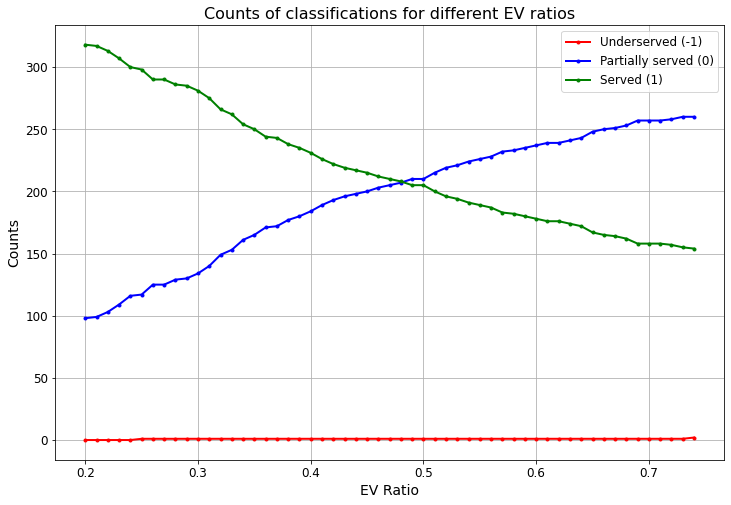

In [161]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each classification on the same axis with specified color, line width and marker
ax.plot(classification_counts.index, classification_counts[-1], label='Underserved (-1)', color='red', linewidth=2.0, marker='o', linestyle='-', markersize=3)
ax.plot(classification_counts.index, classification_counts[0], label='Partially served (0)', color='blue', linewidth=2.0, marker='o', linestyle='-', markersize=3)
ax.plot(classification_counts.index, classification_counts[1], label='Served (1)', color='green', linewidth=2.0, marker='o', linestyle='-', markersize=3)

# Add labels and title with increased font size
ax.set_xlabel('EV Ratio', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Counts of classifications for different EV ratios', fontsize=16)

# Increase tick size
ax.tick_params(axis='both', which='major', labelsize=12)

# Add a grid
ax.grid(True)

# Add a legend with increased font size
ax.legend(fontsize=12)

# Show the plot
plt.show()


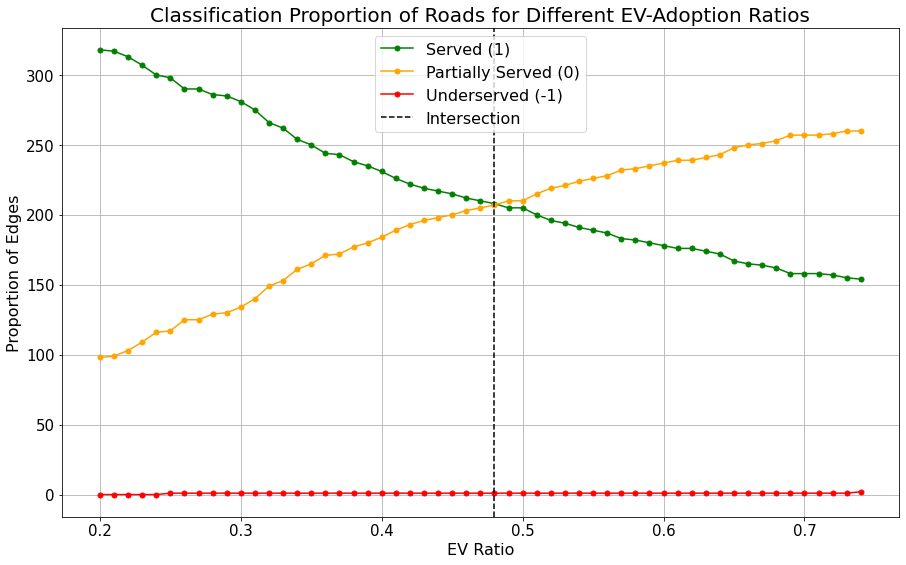

In [162]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 9))

# Plot each classification on the same axis with dot markers
ax.plot(classification_counts.index, classification_counts[1], marker='o', color="green", linestyle='-', markersize=5, label='Served (1)')
ax.plot(classification_counts.index, classification_counts[0], marker='o',color="orange", linestyle='-', markersize=5, label='Partially Served (0)')
ax.plot(classification_counts.index, classification_counts[-1], marker='o', color="red",linestyle='-', markersize=5, label='Underserved (-1)')

# Add labels and title
ax.set_xlabel('EV Ratio', fontsize=16)
ax.set_ylabel('Proportion of Edges', fontsize=16)
ax.set_title('Classification Proportion of Roads for Different EV-Adoption Ratios', fontsize=20)
ax.grid(True)


# Increase the font size of the tick labels
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)


# Find the intersection point of the 'Served (1)' and 'Partially Served (0)' lines
intersection_index = classification_counts[1].sub(classification_counts[0]).abs().idxmin()
intersection_value = classification_counts[1].loc[intersection_index]

# Add a vertical line at the intersection point
ax.axvline(x=intersection_index, color='black', linestyle='--', label="Intersection")

# Add a legend
ax.legend(fontsize=16)

# Show the plot
plt.show()

In [163]:
# Calculate the total counts for each ev_ratio
classification_counts['total'] = classification_counts.sum(axis=1)

# Calculate the proportions for each classification
classification_counts = classification_counts.copy()
classification_counts[-1] = classification_counts[-1] / classification_counts['total']
classification_counts[0] = classification_counts[0] / classification_counts['total']
classification_counts[1] = classification_counts[1] / classification_counts['total']

# Drop the 'total' column as it is not needed anymore
classification_counts_mean_proportions = classification_counts.drop(columns=['total'])

print(classification_counts_mean_proportions)


              1       0      -1
0.20000 0.76442 0.23558 0.00000
0.21000 0.76202 0.23798 0.00000
0.22000 0.75240 0.24760 0.00000
0.23000 0.73798 0.26202 0.00000
0.24000 0.72115 0.27885 0.00000
0.25000 0.71635 0.28125 0.00240
0.26000 0.69712 0.30048 0.00240
0.27000 0.69712 0.30048 0.00240
0.28000 0.68750 0.31010 0.00240
0.29000 0.68510 0.31250 0.00240
0.30000 0.67548 0.32212 0.00240
0.31000 0.66106 0.33654 0.00240
0.32000 0.63942 0.35817 0.00240
0.33000 0.62981 0.36779 0.00240
0.34000 0.61058 0.38702 0.00240
0.35000 0.60096 0.39663 0.00240
0.36000 0.58654 0.41106 0.00240
0.37000 0.58413 0.41346 0.00240
0.38000 0.57212 0.42548 0.00240
0.39000 0.56490 0.43269 0.00240
0.40000 0.55529 0.44231 0.00240
0.41000 0.54327 0.45433 0.00240
0.42000 0.53365 0.46394 0.00240
0.43000 0.52644 0.47115 0.00240
0.44000 0.52163 0.47596 0.00240
0.45000 0.51683 0.48077 0.00240
0.46000 0.50962 0.48798 0.00240
0.47000 0.50481 0.49279 0.00240
0.48000 0.50000 0.49760 0.00240
0.49000 0.49279 0.50481 0.00240
0.50000 

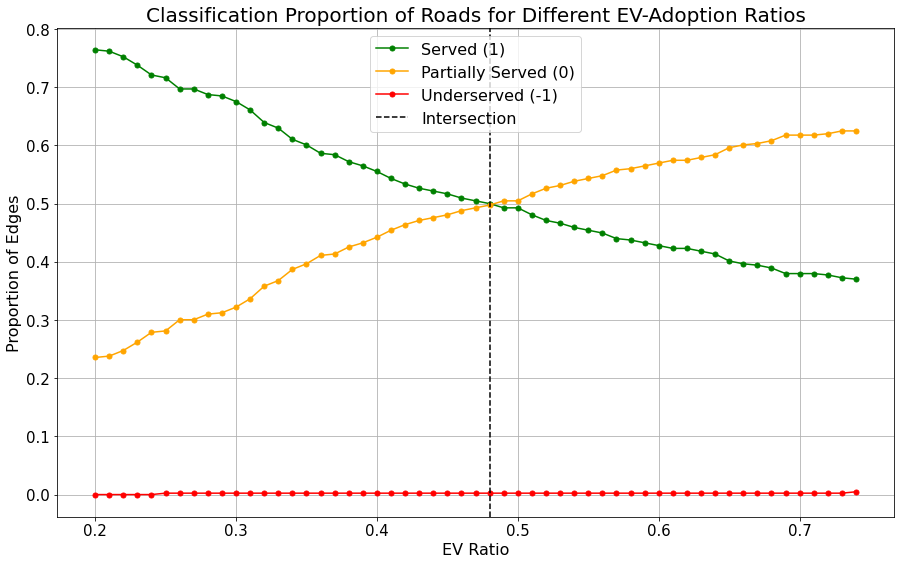

In [164]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 9))

# Plot each classification on the same axis with dot markers
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions[1], marker='o', color="green", linestyle='-', markersize=5, label='Served (1)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions[0], marker='o',color="orange", linestyle='-', markersize=5, label='Partially Served (0)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions[-1], marker='o', color="red",linestyle='-', markersize=5, label='Underserved (-1)')

# Add labels and title
ax.set_xlabel('EV Ratio', fontsize=16)
ax.set_ylabel('Proportion of Edges', fontsize=16)
ax.set_title('Classification Proportion of Roads for Different EV-Adoption Ratios', fontsize=20)
ax.grid(True)


# Increase the font size of the tick labels
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)


# Find the intersection point of the 'Served (1)' and 'Partially Served (0)' lines
intersection_index = classification_counts_mean_proportions[1].sub(classification_counts_mean_proportions[0]).abs().idxmin()
intersection_value = classification_counts_mean_proportions[1].loc[intersection_index]

# Add a vertical line at the intersection point
ax.axvline(x=intersection_index, color='black', linestyle='--', label="Intersection")

# Add a legend
ax.legend(fontsize=16)

# Show the plot
plt.show()


## Plotting sensitivity analysis of adpotion rates on classification data

### Using data from NTP (Tabell V.6 NB19-banene. Bestand av personbiler 2010 - 2050, etter energiteknologi)

### Data from: Electriying the Vehicle Fleet: Projections for Norway 2018-2050
### https://www.toi.no/getfile.php?mmfileid=50202

In [181]:
ad_rate=pd.read_excel(r"/Users/antonglad/Desktop/Python_Recreation/sensitivity/adoption_rate.xlsx")
ad_rate.head()

,Ar,Antall alt,Bensin,Diesel,Ikke- ladbar hybrid,Ladbar hybrid,Batteri,Hydrogen,Annet
0,2010,2294449,1492704,799521,85,0,2068,19,52
1,2011,2357995,1439086,914811,103,0,3898,35,62
2,2012,2422714,1399783,1014549,293,0,8012,20,57
3,2013,2474332,1358655,1095836,1999,0,17714,20,108
4,2014,2525872,1317731,1168448,968,0,38564,21,140


In [182]:
# Calculate ratios
ratios = ad_rate.iloc[:, 2:].div(ad_rate['Antall alt'], axis=0) * 100

# Create the ad_ratio DataFrame
ad_ratio = pd.DataFrame({
    'Year': ad_rate['Ar'],
    'Total': ad_rate['Antall alt'],
    'Bensin_ratio': ratios['Bensin'],
    'Diesel_ratio': ratios['Diesel'],
    'Ikke-ladbar_hybrid_ratio': ratios['Ikke- ladbar hybrid'],
    'Ladbar_hybrid_ratio': ratios['Ladbar hybrid'],
    'Batteri_ratio': ratios['Batteri'],
    'Hydrogen_ratio': ratios['Hydrogen'],
    'Annet_ratio': ratios['Annet']
})

ad_ratio.head()

,Year,Total,Bensin_ratio,Diesel_ratio,Ikke-ladbar_hybrid_ratio,Ladbar_hybrid_ratio,Batteri_ratio,Hydrogen_ratio,Annet_ratio
0,2010,2294449,65.05719,34.84588,0.00370,0.00000,0.09013,0.00083,0.00227
1,2011,2357995,61.03007,38.79614,0.00437,0.00000,0.16531,0.00148,0.00263
2,2012,2422714,57.77748,41.87655,0.01209,0.00000,0.33070,0.00083,0.00235
3,2013,2474332,54.90997,44.28816,0.08079,0.00000,0.71591,0.00081,0.00436
4,2014,2525872,52.16935,46.25919,0.03832,0.00000,1.52676,0.00083,0.00554


In [183]:
ad_ratio.tail()

,Year,Total,Bensin_ratio,Diesel_ratio,Ikke-ladbar_hybrid_ratio,Ladbar_hybrid_ratio,Batteri_ratio,Hydrogen_ratio,Annet_ratio
36,2046,3344599,1.06333,1.82895,0.06557,23.65010,73.38189,0.00966,0.00048
37,2047,3360156,0.95335,1.63284,0.05443,23.27115,74.07900,0.00881,0.00042
38,2048,3372137,0.85898,1.46026,0.04531,22.87535,74.75177,0.00798,0.00036
39,2049,3380975,0.77697,1.30752,0.03771,22.46864,75.40165,0.00722,0.00033
40,2050,3387526,0.70467,1.17177,0.03132,22.05468,76.03074,0.00652,0.00030


### From this we can see that by 2050, around 75% of the whole vehicle fleet will be battery powered, while 22% will be hybrids

## Next step: Altering vehicle range over time

In [184]:
#Many sources which will cnotribute to validity of estimates. We believe that the estimates used are quite conservative
#https://www.statista.com/statistics/970998/range-trends-electric-vehicles/
#Another factor that can be considered is major technological breakthroughs on the horizon of solid-state batteries and shortages of materials used for battery production

import pandas as pd
import numpy as np

# Define the start and end values for battery range
start_range = 300
end_range = 650

# Define the years
start_year = 2023
end_year = 2050

# Calculate the step size for even distribution
step_size = (end_range - start_range) / (end_year - start_year)

# Create the range values
battery_range_values = np.arange(start_range, end_range + step_size, step_size)

# Create the years
years = np.arange(start_year, end_year + 1)

# Create the DataFrame
battery_growth = pd.DataFrame({
    'Year': years,
    'Battery_Range': battery_range_values
})

# Convert the "Battery Range" column to integers
battery_growth['Battery_Range'] = battery_growth['Battery_Range'].astype(int)



In [169]:
battery_growth.head(5)


,Year,Battery_Range
0,2023,300
1,2024,312
2,2025,325
3,2026,338
4,2027,351


In [170]:
battery_growth.tail(5)

,Year,Battery_Range
23,2046,598
24,2047,611
25,2048,624
26,2049,637
27,2050,650


### Altering the function to accept range as a parameter

In [190]:
#Define function which calculates main dataframe values
def process_df_v2(ev_ratio, battery_range, df): 
    df=df.copy()
    #Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
    df["range"]=battery_range

    #Creating dictionairy showcasing the loss of range per season 
    temp_cost={'january':0.8, 
            'february':0.8, 
            'march':0.8, 
            'april':0.9, 
            'may':1, 
            'june':1.05, 
            'july':1.1, 
            'august':1.1, 
            'september':1.02, 
            'october':0.92, 
            'november':0.82, 
            'december':0.8} 

    #Part of Method 1
    for key in temp_cost.keys():
        df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]



    # Define a dictionary to map the old column names to the new column names
    col_map = {i: f"vol_{month[:3].lower().strip()}" for i, month in zip(range(1, 13), temp_cost.keys())}

    # Manually change the column names
    #new_names = {'1': 'vol_jan', '2': 'vol_feb', '3': 'vol_mar', '4': 'vol_apr', '5': 'vol_may', '6': 'vol_jun', '7': 'vol_jul', '8': 'vol_aug', '9': 'vol_sep', '10': 'vol_oct', '11': 'vol_nov', '12': 'vol_dec'}
    new_names = {1: 'vol_jan', 2: 'vol_feb', 3: 'vol_mar', 4: 'vol_apr', 5: 'vol_may', 6: 'vol_jun', 7: 'vol_jul', 8: 'vol_aug', 9: 'vol_sep', 10: 'vol_oct', 11: 'vol_nov', 12: 'vol_dec'}

    # Rename the columns using the dictionary
    df = df.rename(columns=new_names)

    # Loop through each row of the dataframe
    for index, row in df.iterrows():
        # Calculate the mean of the non-missing values in the row
        row_mean = int(row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True))

        # Fill the missing values in the row with the row mean
        df.loc[index] = row.fillna(row_mean)


    # Find charging probability distribution
    #Formula: p = edge_length / battery_range (actual)

    #Method 1: Decreases the range by a factor of temperature
    # # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_prob_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)
        df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)


    ################################################################
    
    #public_charging=X

    # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_cars_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
        df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio) #*public_charging
        df[col_name] = df[col_name].astype(int)



    # Define a list of the column names to convert to integer type
    cols_to_convert = ['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 
                    'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec', 
                    'range', 'actual_range_jan', 'actual_range_feb', 'actual_range_mar', 
                    'actual_range_apr', 'actual_range_may', 'actual_range_jun', 
                    'actual_range_jul', 'actual_range_aug', 'actual_range_sep', 
                    'actual_range_oct', 'actual_range_nov', 'actual_range_dec']

    # Convert the columns to integer type
    df[cols_to_convert] = df[cols_to_convert].astype(int)

    return df

### Create a dataframe with both range and EV ratio on the same timeframe

In [191]:
# Define the start and end values for EV ratio
start_ev_ratio = 0.2
end_ev_ratio = 0.75

# Calculate the step size for EV ratio
step_size_ev_ratio = (end_ev_ratio - start_ev_ratio) / (end_year - start_year)

# Create the EV ratio values
ev_ratio_values = np.arange(start_ev_ratio, end_ev_ratio + step_size_ev_ratio, step_size_ev_ratio)

# Make sure the sequences are of same length
assert len(years) == len(ev_ratio_values)

# Create the DataFrame
ev_ratio_growth = pd.DataFrame({
    'Year': years,
    'EV_Ratio': ev_ratio_values
})

# Now you can merge the two dataframes on the 'Year' column
growth_df = pd.merge(ev_ratio_growth, battery_growth, on='Year')

# Make sure to round or cast the EV_Ratio to the desired number of decimals or type
growth_df['EV_Ratio'] = growth_df['EV_Ratio'].round(decimals=2)

print(growth_df)


    Year  EV_Ratio  Battery_Range
0   2023   0.20000            300
1   2024   0.22000            312
2   2025   0.24000            325
3   2026   0.26000            338
4   2027   0.28000            351
5   2028   0.30000            364
6   2029   0.32000            377
7   2030   0.34000            390
8   2031   0.36000            403
9   2032   0.38000            416
10  2033   0.40000            429
11  2034   0.42000            442
12  2035   0.44000            455
13  2036   0.46000            468
14  2037   0.49000            481
15  2038   0.51000            494
16  2039   0.53000            507
17  2040   0.55000            520
18  2041   0.57000            533
19  2042   0.59000            546
20  2043   0.61000            559
21  2044   0.63000            572
22  2045   0.65000            585
23  2046   0.67000            598
24  2047   0.69000            611
25  2048   0.71000            624
26  2049   0.73000            637
27  2050   0.75000            650


### Sensitivity 2: Running the sensititivty with changing both ranges and ratios together on the same timeframe

In [203]:
from tqdm import tqdm
from functools import reduce

# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()

avg_bat = 68 * 0.9

# Make a copy of the original dataframe
df_orig = df.copy()

def classify(row):
    if (row < 0).all():             # all values are negative
        return -1
    elif (row > 0).all():           # all values are positive
        return 1
    else:                           # values are mixed
        return 0

# Iterate over the rows of the growth DataFrame
for _, row in tqdm(growth_df.iterrows(), desc='Processing rows'):
    # Extract the EV ratio and battery range for this year
    ev_ratio = row['EV_Ratio']
    battery_range = row['Battery_Range']

    # Process the DataFrame
    df_temp = df_orig.copy() # use a copy of the original DataFrame
    df_temp = process_df_v2(ev_ratio, battery_range, df_temp)

    # Process the JSON data
    supply_demand_difference = process_json(df_temp, mean_ratios, avg_bat)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize an empty list to store all the dataframes
    all_dfs = []

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for ev_ratio={ev_ratio}, battery_range={battery_range}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()

        # Rename the columns to include the month as a suffix
        monthly_df = monthly_df.rename(columns=lambda x: f'{x}_{month}' if 'diff_hour' in x else x)

        # Append the dataframe to the list
        all_dfs.append(monthly_df)

    # Use merge to join all dataframes on 'u' and 'v'
    all_months = reduce(lambda left, right: pd.merge(left, right, on=['u', 'v'], how='outer'), all_dfs)

    # Filter columns containing 'diff_hour'
    diff_hour_cols = [col for col in all_months.columns if 'diff_hour' in col]

    # Apply the classification function to each row
    all_months['edge_classification'] = all_months[diff_hour_cols].apply(classify, axis=1)

    # Count the occurrences of each classification
    counts = all_months["edge_classification"].value_counts()

    # Store the counts in a DataFrame
    ev_ratio_counts = pd.DataFrame(counts).transpose()
    ev_ratio_counts['EV_Ratio'] = ev_ratio
    ev_ratio_counts['Battery_Range'] = battery_range

    # Append the ev_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, ev_ratio_counts])

    # Fill any missing values with 0
    classification_counts = classification_counts.fillna(0)

# Reset the index of the classification_counts DataFrame
classification_counts.reset_index(drop=True, inplace=True)

# Calculate the mean counts for each pair of EV_Ratio and Battery_Range
classification_counts_mean = classification_counts.groupby(['EV_Ratio', 'Battery_Range']).mean()

print(classification_counts_mean)



Processing rows: 28it [03:39,  7.83s/it]

                               1         0      -1
EV_Ratio Battery_Range                            
0.20000  300.00000     318.00000  98.00000 0.00000
0.22000  312.00000     315.00000 101.00000 0.00000
0.24000  325.00000     312.00000 104.00000 0.00000
0.26000  338.00000     306.00000 110.00000 0.00000
0.28000  351.00000     301.00000 115.00000 0.00000
0.30000  364.00000     298.00000 118.00000 0.00000
0.32000  377.00000     295.00000 120.00000 1.00000
0.34000  390.00000     290.00000 125.00000 1.00000
0.36000  403.00000     290.00000 125.00000 1.00000
0.38000  416.00000     287.00000 128.00000 1.00000
0.40000  429.00000     286.00000 129.00000 1.00000
0.42000  442.00000     286.00000 129.00000 1.00000
0.44000  455.00000     285.00000 130.00000 1.00000
0.46000  468.00000     284.00000 131.00000 1.00000
0.49000  481.00000     275.00000 140.00000 1.00000
0.51000  494.00000     275.00000 140.00000 1.00000
0.53000  507.00000     271.00000 144.00000 1.00000
0.55000  520.00000     267.0000

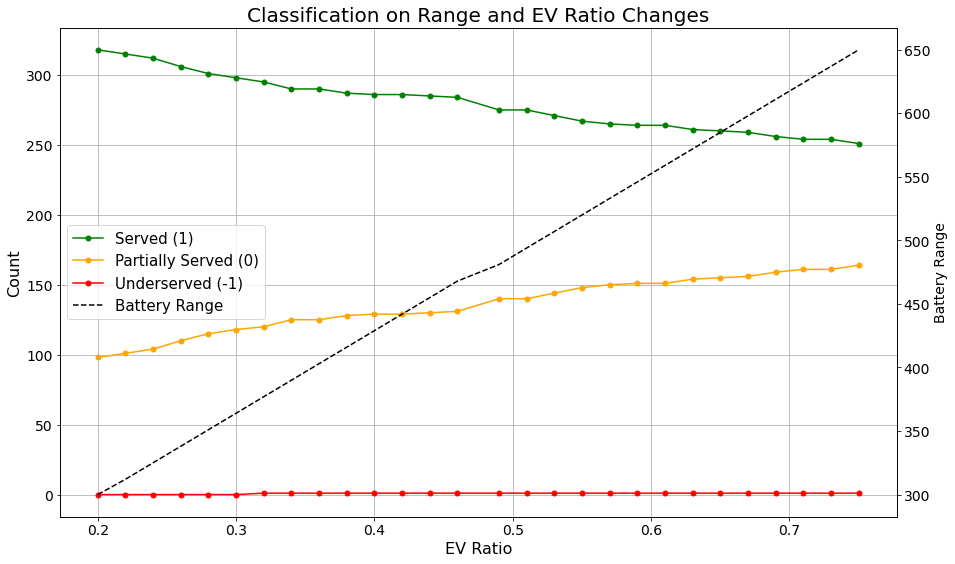

In [207]:
fig, ax1 = plt.subplots(figsize=(15, 9))

# Define a dictionary to map classes to labels and colors
class_labels = {-1: 'Underserved (-1)', 0: 'Partially Served (0)', 1: 'Served (1)'}
class_colors = {1: 'green', 0: 'orange', -1: 'red'}

# Plot the lines for classification counts on the first y-axis with the corresponding colors
for classif in [1, 0, -1]:
    ax1.plot(classification_counts_mean.index.get_level_values('EV_Ratio'), classification_counts_mean[classif], label=class_labels[classif], color=class_colors[classif], marker='o', markersize=5)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the line for Battery Range on the second y-axis
ax2.plot(growth_df['EV_Ratio'], growth_df['Battery_Range'], label='Battery Range', linestyle='--', color="black")

# Add labels and title
ax1.set_xlabel('EV Ratio', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax2.set_ylabel('Battery Range', fontsize=14)
ax1.grid(True)
plt.title('Classification on Range and EV Ratio Changes', fontsize=20)

# Add legend with custom order
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=6, fontsize=15)

# Increase the font size of the tick labels
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.show()


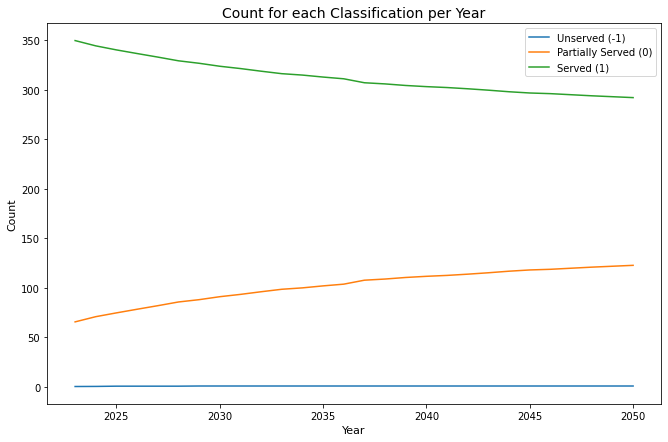

In [65]:
# Rename the 'EV_Ratio' column in growth_df to 'ev_ratio' to match classification_counts_mean
growth_df = growth_df.rename(columns={'EV_Ratio': 'ev_ratio'})
classification_counts_mean = classification_counts_mean.rename(columns={'EV_Ratio': 'ev_ratio'})


# Merge the classification_counts_mean DataFrame with the growth_df DataFrame on 'ev_ratio'
merged_df = pd.merge(classification_counts_mean.reset_index(), growth_df, on='ev_ratio')


fig, ax1 = plt.subplots(figsize=(11, 7))

# Define a dictionary to map classes to labels
class_labels = {'-1': 'Unserved (-1)', '0': 'Partially Served (0)', '1': 'Served (1)'}

# Plot the lines for classification counts on the first y-axis
for classif in ['-1', '0', '1']:
    subset = merged_df.copy()
    ax1.plot(subset['Year'], subset[classif], label=class_labels[classif])

# Add labels and title
ax1.set_xlabel('Year', fontsize= 11)
ax1.set_ylabel('Count', fontsize= 11)
ax1.grid(False)
plt.title('Count for each Classification per Year', fontsize= 14)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc=0)

plt.show()

# # Show the dataframe
# merged_df[['Year', 'ev_ratio', 'Battery_Range']]


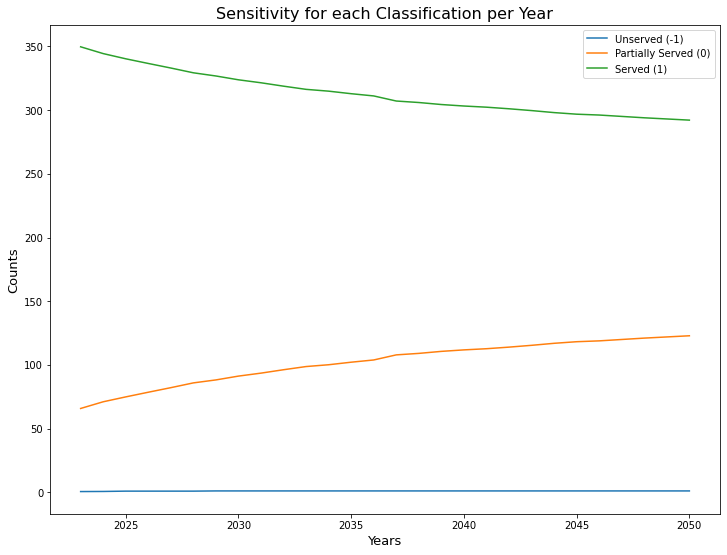

In [66]:
# Rename the 'EV_Ratio' column in growth_df to 'ev_ratio' to match classification_counts_mean
growth_df = growth_df.rename(columns={'EV_Ratio': 'ev_ratio'})
classification_counts_mean = classification_counts_mean.rename(columns={'EV_Ratio': 'ev_ratio'})

# Plotting the lines for each class on the same y-axis
fig, ax = plt.subplots(figsize=(12, 9))

# Define a dictionary to map classes to labels
class_labels = {'-1': 'Unserved (-1)', '0': 'Partially Served (0)', '1': 'Served (1)'}

# For each class, plot a line
for classif in ['-1', '0', '1']:
    ax.plot(growth_df['Year'], classification_counts_mean[classif], label=class_labels[classif])

# Add labels and title
ax.set_xlabel('Years', fontsize= 13)
ax.set_ylabel('Counts', fontsize= 13)
plt.title('Sensitivity for each Classification per Year', fontsize= 16)

# Add legend
ax.legend(loc=0)

plt.show()


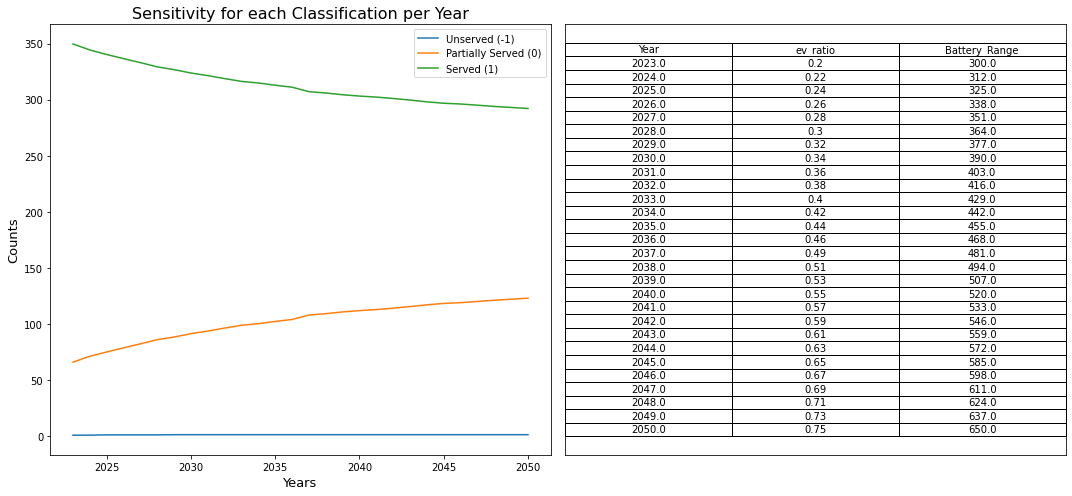

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1]})

# Define a dictionary to map classes to labels
class_labels = {'-1': 'Unserved (-1)', '0': 'Partially Served (0)', '1': 'Served (1)'}

# Plot the lines for classification counts on the first y-axis
for classif in ['-1', '0', '1']:
    subset = merged_df.copy()
    ax1.plot(subset['Year'], subset[classif], label=class_labels[classif])

# Add labels and title
ax1.set_xlabel('Years', fontsize= 13)
ax1.set_ylabel('Counts', fontsize= 13)
ax1.grid(False)
ax1.set_title('Sensitivity for each Classification per Year', fontsize= 16)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc=0)

# Remove ticks from the table subplot
ax2.set_xticks([])
ax2.set_yticks([])

# Add a table at the bottom of the axes
columns = ['Year', 'ev_ratio', 'Battery_Range']
cell_text = []

for row in range(len(growth_df)):
    cell_text.append(growth_df.iloc[row][columns].values.tolist())

table = ax2.table(cellText=cell_text, colLabels=columns, cellLoc = 'center', loc='center')

# Show the plot
plt.tight_layout()
plt.show()


## Sensitivity 3: on battery range, EV-ratio of fleet, and average battery capacity of vehicles

In [208]:
# Define the start and end values for avg_bat
start_avg_bat = 68
end_avg_bat = 90

start_avg_bat*=0.9
end_avg_bat*=0.9

# Calculate the step size for avg_bat
step_size_avg_bat = (end_avg_bat - start_avg_bat) / (growth_df['Year'].max() - growth_df['Year'].min())

# Create the avg_bat values
avg_bat_values = np.arange(start_avg_bat, end_avg_bat + step_size_avg_bat, step_size_avg_bat)

# Make sure the sequences are of the same length
assert len(growth_df) == len(avg_bat_values)

# Add the avg_bat values to the DataFrame
growth_df['Avg_Bat'] = avg_bat_values

# Make sure to round or cast the Avg_Bat to the desired number of decimals or type
growth_df['Avg_Bat'] = growth_df['Avg_Bat'].round(decimals=2)

print(growth_df)


    Year  EV_Ratio  Battery_Range  Avg_Bat
0   2023   0.20000            300 61.20000
1   2024   0.22000            312 61.93000
2   2025   0.24000            325 62.67000
3   2026   0.26000            338 63.40000
4   2027   0.28000            351 64.13000
5   2028   0.30000            364 64.87000
6   2029   0.32000            377 65.60000
7   2030   0.34000            390 66.33000
8   2031   0.36000            403 67.07000
9   2032   0.38000            416 67.80000
10  2033   0.40000            429 68.53000
11  2034   0.42000            442 69.27000
12  2035   0.44000            455 70.00000
13  2036   0.46000            468 70.73000
14  2037   0.49000            481 71.47000
15  2038   0.51000            494 72.20000
16  2039   0.53000            507 72.93000
17  2040   0.55000            520 73.67000
18  2041   0.57000            533 74.40000
19  2042   0.59000            546 75.13000
20  2043   0.61000            559 75.87000
21  2044   0.63000            572 76.60000
22  2045   

Testing sensitivity new 3:

In [210]:
# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()

# Iterate over the rows of the growth DataFrame
for _, row in tqdm(growth_df.iterrows(), desc='Processing rows'):
    # Extract the EV ratio, battery range, and avg_bat for this year
    ev_ratio = row['EV_Ratio']
    battery_range = row['Battery_Range']
    avg_bat = row['Avg_Bat']

    # Process the DataFrame
    df_temp = df.copy()
    df_temp = process_df_v2(ev_ratio, battery_range, df_temp) # ensure that process_df_v2() can accept and process avg_bat

    # Process the JSON data
    supply_demand_difference = process_json(df_temp, mean_ratios, avg_bat)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize an empty list to store all the dataframes
    all_dfs = []

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for ev_ratio={ev_ratio}, battery_range={battery_range}, avg_bat={avg_bat}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()

        # Rename the columns to include the month as a suffix
        monthly_df = monthly_df.rename(columns=lambda x: f'{x}_{month}' if 'diff_hour' in x else x)

        # Append the dataframe to the list
        all_dfs.append(monthly_df)

    # Use merge to join all dataframes on 'u' and 'v'
    all_months = reduce(lambda left, right: pd.merge(left, right, on=['u', 'v'], how='outer'), all_dfs)

    # Filter columns containing 'diff_hour'
    diff_hour_cols = [col for col in all_months.columns if 'diff_hour' in col]

    # Apply the classification function to each row
    all_months['edge_classification'] = all_months[diff_hour_cols].apply(classify, axis=1)

    # Count the occurrences of each classification
    counts = all_months["edge_classification"].value_counts()

    # Store the counts in a DataFrame
    ev_ratio_counts = pd.DataFrame(counts).transpose()
    ev_ratio_counts['EV_Ratio'] = ev_ratio
    ev_ratio_counts['Battery_Range'] = battery_range
    ev_ratio_counts['Avg_Bat'] = avg_bat

    # Append the ev_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, ev_ratio_counts])

    # Fill any missing values with 0
    classification_counts = classification_counts.fillna(0)

# Reset the index of the classification_counts DataFrame
classification_counts.reset_index(drop=True, inplace=True)

# Calculate the mean counts for each pair of EV_Ratio, Battery_Range, and Avg_Bat
classification_counts_mean = classification_counts.groupby(['EV_Ratio', 'Battery_Range', 'Avg_Bat']).mean()

print(classification_counts_mean)


Processing rows: 28it [03:43,  7.97s/it]

                                        1         0      -1
EV_Ratio Battery_Range Avg_Bat                             
0.20000  300.00000     61.20000 318.00000  98.00000 0.00000
0.22000  312.00000     61.93000 315.00000 101.00000 0.00000
0.24000  325.00000     62.67000 311.00000 105.00000 0.00000
0.26000  338.00000     63.40000 305.00000 111.00000 0.00000
0.28000  351.00000     64.13000 300.00000 116.00000 0.00000
0.30000  364.00000     64.87000 297.00000 119.00000 0.00000
0.32000  377.00000     65.60000 294.00000 121.00000 1.00000
0.34000  390.00000     66.33000 290.00000 125.00000 1.00000
0.36000  403.00000     67.07000 288.00000 127.00000 1.00000
0.38000  416.00000     67.80000 286.00000 129.00000 1.00000
0.40000  429.00000     68.53000 286.00000 129.00000 1.00000
0.42000  442.00000     69.27000 285.00000 130.00000 1.00000
0.44000  455.00000     70.00000 262.00000 153.00000 1.00000
0.46000  468.00000     70.73000 260.00000 155.00000 1.00000
0.49000  481.00000     71.47000 250.0000

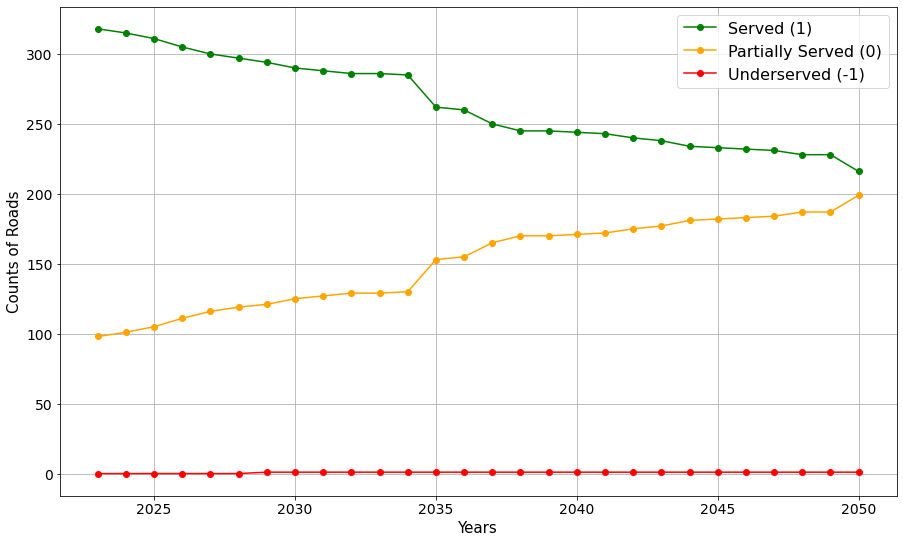

In [214]:
# Rename the 'EV_Ratio' column in growth_df to 'ev_ratio' to match classification_counts_mean
growth_df = growth_df.rename(columns={'EV_Ratio': 'ev_ratio'})
classification_counts_mean = classification_counts_mean.rename(columns={'EV_Ratio': 'ev_ratio'})

# Plotting the lines for each class on the same y-axis
fig, ax = plt.subplots(figsize=(15, 9))

# Define a dictionary to map classes to labels and colors
class_labels = {-1: 'Underserved (-1)', 0: 'Partially Served (0)', 1: 'Served (1)'}
class_colors = {-1: 'red', 0: 'orange', 1: 'green'}

# Initialize empty lists to store handles and labels
handles = []
labels = []

# For each class, plot a line with the corresponding color and add to handles and labels
for classif in [1, 0, -1]:
    line, = ax.plot(growth_df['Year'], classification_counts_mean[classif], marker='o', color=class_colors[classif], label=class_labels[classif])
    handles.append(line)
    labels.append(class_labels[classif])

# Add labels and title
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('Counts of Roads', fontsize=15)
ax.grid(True)
#plt.title('Sensitivity for each Classification per Year', fontsize=20)

# Add legend with custom order
ax.legend(handles, labels, fontsize=16, loc=0)

# Increase the font size of the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.show()


## Sensitivity on battery capacity

In [12]:
from tqdm import tqdm
#Takes about 6 minutes to run

# Specify the values of ev_ratio to use in the sensitivity analysis
avg_bat = np.arange(50, 90, 1)

# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()
ev_ratio=0.2

# Iterate over the values of ev_ratio
for cap in tqdm(avg_bat, desc='Processing battery capacities'):
    # Process the DataFrame
    df = process_df(ev_ratio, df)
    
    # Process the JSON data
    supply_demand_difference = process_json(df, mean_ratios, cap)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize a DataFrame to store the counts for this value of ev_ratio
    battery_ratio_counts = pd.DataFrame(index=months, columns=["-1", "0", "1"])

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for Battery Capacity={cap}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()

        # Count the occurrences of each classification
        counts = monthly_df["edge_classification"].value_counts()

        # Add the counts to the ev_ratio_counts DataFrame
        battery_ratio_counts.loc[month] = [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

    # Add ev_ratio column to ev_ratio_counts
    battery_ratio_counts['avg_bat'] = cap

    # Append the ev_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, battery_ratio_counts.reset_index().rename(columns={'index': 'month'})])

# Calculate the mean counts for each ev_ratio
classification_counts_mean = classification_counts.groupby('avg_bat').mean()

print(classification_counts_mean)


Processing battery capacities: 100%|██████████| 40/40 [06:54<00:00, 10.36s/it]

             -1        0         1
avg_bat                           
50      0.00000 50.58333 365.41667
51      0.00000 51.25000 364.75000
52      0.00000 51.66667 364.33333
53      0.00000 52.58333 363.41667
54      0.08333 57.91667 358.00000
55      0.08333 58.33333 357.58333
56      0.08333 58.33333 357.58333
57      0.08333 58.41667 357.50000
58      0.08333 59.08333 356.83333
59      0.08333 59.66667 356.25000
60      0.08333 60.58333 355.33333
61      0.50000 65.75000 349.75000
62      0.50000 65.75000 349.75000
63      0.50000 66.50000 349.00000
64      0.50000 66.83333 348.66667
65      0.50000 66.83333 348.66667
66      0.50000 67.41667 348.08333
67      0.50000 67.58333 347.91667
68      0.50000 69.25000 346.25000
69      0.50000 69.58333 345.91667
70      0.83333 78.50000 336.66667
71      0.83333 78.50000 336.66667
72      0.83333 79.25000 335.91667
73      0.83333 79.25000 335.91667
74      0.83333 80.00000 335.16667
75      0.83333 80.25000 334.91667
76      0.83333 80.2

### convert to proportions

In [13]:
# Calculate the total counts for each ev_ratio
classification_counts_mean['total'] = classification_counts_mean.sum(axis=1)

# Calculate the proportions for each classification
classification_counts_mean_proportions = classification_counts_mean.copy()
classification_counts_mean_proportions["-1"] = classification_counts_mean["-1"] / classification_counts_mean['total']
classification_counts_mean_proportions["0"] = classification_counts_mean["0"] / classification_counts_mean['total']
classification_counts_mean_proportions["1"] = classification_counts_mean["1"] / classification_counts_mean['total']

# Drop the 'total' column as it is not needed anymore
classification_counts_mean_proportions = classification_counts_mean_proportions.drop(columns=['total'])

print(classification_counts_mean_proportions)


             -1       0       1
avg_bat                        
50      0.00000 0.12159 0.87841
51      0.00000 0.12320 0.87680
52      0.00000 0.12420 0.87580
53      0.00000 0.12640 0.87360
54      0.00020 0.13922 0.86058
55      0.00020 0.14022 0.85958
56      0.00020 0.14022 0.85958
57      0.00020 0.14042 0.85938
58      0.00020 0.14203 0.85777
59      0.00020 0.14343 0.85637
60      0.00020 0.14563 0.85417
61      0.00120 0.15805 0.84075
62      0.00120 0.15805 0.84075
63      0.00120 0.15986 0.83894
64      0.00120 0.16066 0.83814
65      0.00120 0.16066 0.83814
66      0.00120 0.16206 0.83674
67      0.00120 0.16246 0.83634
68      0.00120 0.16647 0.83233
69      0.00120 0.16727 0.83153
70      0.00200 0.18870 0.80929
71      0.00200 0.18870 0.80929
72      0.00200 0.19050 0.80749
73      0.00200 0.19050 0.80749
74      0.00200 0.19231 0.80569
75      0.00200 0.19291 0.80509
76      0.00200 0.19291 0.80509
77      0.00200 0.19371 0.80429
78      0.00200 0.19371 0.80429
79      

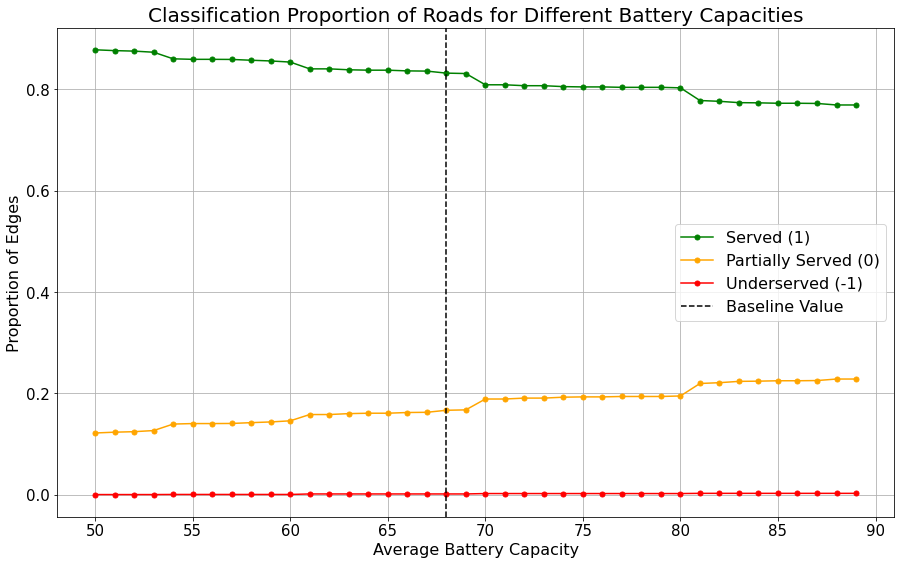

In [27]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 9))

# Plot each classification on the same axis with dot markers
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions['1'], marker='o',color="green", linestyle='-', markersize=5, label='Served (1)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions['0'], marker='o', color="orange",linestyle='-', markersize=5, label='Partially Served (0)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions['-1'], marker='o', color="red", linestyle='-', markersize=5, label='Underserved (-1)')
# Add labels and title
ax.set_xlabel('Average Battery Capacity', fontsize=16)
ax.set_ylabel('Proportion of Edges', fontsize=16)
ax.set_title('Classification Proportion of Roads for Different Battery Capacities', fontsize=20)
ax.grid(True)
# Add a legend


# Increase the font size of the tick labels
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# Add a vertical line at x-axis = 68
ax.axvline(x=68, color='black', linestyle='--', label='Baseline Value')

ax.legend(fontsize=16)


# Show the plot
plt.show()


## Sensitivity on range alone

### Need to update function to include range parameter

In [230]:
def process_df_3(ev_ratio, df, car_range): 
    df=df.copy()
    #Adding range of vehicles, lot of analysis to be done here (can also create custom ranges for for different regions...)
    df["range"]=car_range

    #Creating dictionairy showcasing the loss of range per season 
    temp_cost={'january':0.8, 
            'february':0.8, 
            'march':0.8, 
            'april':0.9, 
            'may':1, 
            'june':1.05, 
            'july':1.1, 
            'august':1.1, 
            'september':1.02, 
            'october':0.92, 
            'november':0.82, 
            'december':0.8} 

    #Part of Method 1
    for key in temp_cost.keys():
        df.loc[:, f'actual_range_{key[:3].lower()}'] = df['range'] * temp_cost[key]



    # Define a dictionary to map the old column names to the new column names
    col_map = {i: f"vol_{month[:3].lower().strip()}" for i, month in zip(range(1, 13), temp_cost.keys())}

    # Manually change the column names
    new_names = {1: 'vol_jan', 2: 'vol_feb', 3: 'vol_mar', 4: 'vol_apr', 5: 'vol_may', 6: 'vol_jun', 7: 'vol_jul', 8: 'vol_aug', 9: 'vol_sep', 10: 'vol_oct', 11: 'vol_nov', 12: 'vol_dec'}

    # Rename the columns using the dictionary
    df = df.rename(columns=new_names)

    # Loop through each row of the dataframe
    for index, row in df.iterrows():
        # Calculate the mean of the non-missing values in the row
        row_mean = int(row[['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec']].mean(skipna=True))

        # Fill the missing values in the row with the row mean
        df.loc[index] = row.fillna(row_mean)


    # Find charging probability distribution
    #Formula: p = edge_length / battery_range (actual)

    #Method 1: Decreases the range by a factor of temperature
    # # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_prob_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual range column, (multiplied by 1000 because range is in km, while length is in meters)
        df[col_name] = df['length'] / (df[f'actual_range_{month[:3].lower()}'] * 1000)


    ################################################################
    
    #public_charging=X

    # Loop through each month in the temp_cost dictionary
    for month in temp_cost.keys():
        # Create a new column name for the charging probability
        col_name = f"charge_cars_{month[:3].lower()}"
        # Calculate the charging probability using the corresponding actual length column and a fixed range of 300 (remove public charging variable)
        df[col_name] = ((df[f'vol_{month[:3].lower()}'] * (df[f'charge_prob_{month[:3].lower()}'])) * ev_ratio) #*public_charging
        df[col_name] = df[col_name].astype(int)



    # Define a list of the column names to convert to integer type
    cols_to_convert = ['vol_jan', 'vol_feb', 'vol_mar', 'vol_apr', 'vol_may', 'vol_jun', 
                    'vol_jul', 'vol_aug', 'vol_sep', 'vol_oct', 'vol_nov', 'vol_dec', 
                    'range', 'actual_range_jan', 'actual_range_feb', 'actual_range_mar', 
                    'actual_range_apr', 'actual_range_may', 'actual_range_jun', 
                    'actual_range_jul', 'actual_range_aug', 'actual_range_sep', 
                    'actual_range_oct', 'actual_range_nov', 'actual_range_dec']

    # Convert the columns to integer type
    df[cols_to_convert] = df[cols_to_convert].astype(int)


    return df


In [242]:
from tqdm import tqdm
from functools import reduce

# Specify the values of ev_range to use in the sensitivity analysis
ev_range = np.arange(200, 550, 5)

# Initialize a DataFrame to store the counts
classification_counts = pd.DataFrame()

avg_bat=68
avg_bat*=0.9
ev_ratio=0.20

# Make a copy of the original dataframe
df_orig = df.copy()

def classify(row):
    if (row < 0).all():             # all values are negative
        return -1
    elif (row > 0).all():           # all values are positive
        return 1
    else:                           # values are mixed
        return 0

# Iterate over the values of ev_range
for i in tqdm(ev_range, desc='Processing battery capacities'):
    # Process the DataFrame
    df_temp = df_orig.copy()
    df_temp = process_df_3(ev_ratio=ev_ratio, df=df_temp, car_range=i)

    # Process the JSON data
    supply_demand_difference = process_json(df_temp, mean_ratios, avg_bat)

    # Prepare a list of month abbreviations
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Initialize an empty list to store all the dataframes
    all_dfs = []

    # Iterate over each month
    for month in tqdm(months, desc=f'Processing months for range={i}', leave=False):
        # Get the corresponding DataFrame for the month
        monthly_df = supply_demand_difference[month].copy()

        # Rename the columns to include the month as a suffix
        monthly_df = monthly_df.rename(columns=lambda x: f'{x}_{month}' if 'diff_hour' in x else x)

        # Append the dataframe to the list
        all_dfs.append(monthly_df)

    # Use merge to join all dataframes on 'u' and 'v'
    all_months = reduce(lambda left, right: pd.merge(left, right, on=['u', 'v'], how='outer'), all_dfs)

    # Filter columns containing 'diff_hour'
    diff_hour_cols = [col for col in all_months.columns if 'diff_hour' in col]

    # Apply the classification function to each row
    all_months['edge_classification'] = all_months[diff_hour_cols].apply(classify, axis=1)

    # Count the occurrences of each classification
    counts = all_months["edge_classification"].value_counts()

    # Store the counts in a DataFrame
    range_ratio_counts = pd.DataFrame(counts).transpose()
    range_ratio_counts['car_range'] = i

    # Append the range_ratio_counts DataFrame to the classification_counts DataFrame
    classification_counts = pd.concat([classification_counts, range_ratio_counts])

    # Fill any missing values with 0
    classification_counts = classification_counts.fillna(0)

# Reset the index of the classification_counts DataFrame
#classification_counts.reset_index(drop=True, inplace=True)

# Calculate the mean counts for each car_range
#classification_counts_mean = classification_counts.groupby('car_range').mean()

print(classification_counts)

Processing battery capacities: 100%|██████████| 70/70 [09:11<00:00,  7.88s/it]

                       1    0      -1  car_range
edge_classification  281  134 1.00000        200
edge_classification  285  130 1.00000        205
edge_classification  286  129 1.00000        210
edge_classification  286  129 1.00000        215
edge_classification  289  126 1.00000        220
...                  ...  ...     ...        ...
edge_classification  365   51 0.00000        525
edge_classification  365   51 0.00000        530
edge_classification  365   51 0.00000        535
edge_classification  366   50 0.00000        540
edge_classification  366   50 0.00000        545

[70 rows x 4 columns]


In [244]:
classification_counts = classification_counts.set_index('car_range')


In [245]:
# Calculate the total counts for each ev_ratio
classification_counts['total'] = classification_counts.sum(axis=1)

# Calculate the proportions for each classification
classification_counts_mean_proportions = classification_counts.copy()
classification_counts_mean_proportions[-1] = classification_counts[-1] / classification_counts['total']
classification_counts_mean_proportions[0] = classification_counts[0] / classification_counts['total']
classification_counts_mean_proportions[1] = classification_counts[1] / classification_counts['total']

# Drop the 'total' column as it is not needed anymore
classification_counts_mean_proportions = classification_counts_mean_proportions.drop(columns=['total'])

print(classification_counts_mean_proportions)

                1       0      -1
car_range                        
200       0.67548 0.32212 0.00240
205       0.68510 0.31250 0.00240
210       0.68750 0.31010 0.00240
215       0.68750 0.31010 0.00240
220       0.69471 0.30288 0.00240
...           ...     ...     ...
525       0.87740 0.12260 0.00000
530       0.87740 0.12260 0.00000
535       0.87740 0.12260 0.00000
540       0.87981 0.12019 0.00000
545       0.87981 0.12019 0.00000

[70 rows x 3 columns]


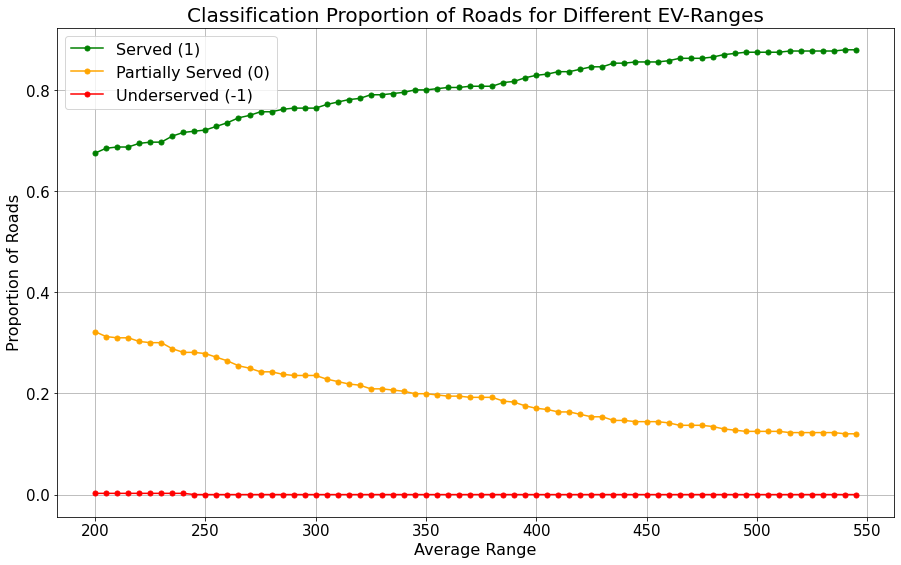

In [246]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 9))

# Plot each classification on the same axis with dot markers
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions[1], marker='o',color="green", linestyle='-', markersize=5, label='Served (1)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions[0], marker='o', color="orange",linestyle='-', markersize=5, label='Partially Served (0)')
ax.plot(classification_counts_mean_proportions.index, classification_counts_mean_proportions[-1], marker='o', color="red", linestyle='-', markersize=5, label='Underserved (-1)')
# Add labels and title
ax.set_xlabel('Average Range', fontsize=16)
ax.set_ylabel('Proportion of Roads', fontsize=16)
ax.set_title('Classification Proportion of Roads for Different EV-Ranges', fontsize=20)
ax.grid(True)
# Add a legend


# Increase the font size of the tick labels
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# Add a vertical line at x-axis = 68
#ax.axvline(x=68, color='black', linestyle='--', label='Baseline Value')

ax.legend(fontsize=16)


# Show the plot
plt.show()